In [26]:
import pickle as pkl
with open("../../wheelway/data/obstruction_spots_gt_1_low_gamma.pkl", 'rb') as pklfile:
    obstruction_spots_gt_1 = pkl.load(pklfile)
    
with open("../../wheelway/data/obstruction_spots_gt_2_low_gamma.pkl", 'rb') as pklfile:
    obstruction_spots_gt_2 = pkl.load(pklfile)
    
with open("../../wheelway/data/surface_spots_gt_1_low_gamma.pkl", 'rb') as pklfile:
    surface_spots_gt_1 = pkl.load(pklfile)
    
with open("../../wheelway/data/surface_spots_gt_2_low_gamma.pkl", 'rb') as pklfile:
    surface_spots_gt_2 = pkl.load(pklfile)


In [27]:
import pandas as pd
df_o_1 = pd.DataFrame(obstruction_spots_gt_1).drop(columns=['predictions'])
df_o_2 = pd.DataFrame(obstruction_spots_gt_2).drop(columns=['predictions'])
df_s_1 = pd.DataFrame(surface_spots_gt_1).drop(columns=['predictions'])
df_s_2 = pd.DataFrame(surface_spots_gt_2).drop(columns=['predictions'])


In [28]:
df_o_1['point'] = list(zip(df_o_1['lng'], df_o_1['lat']))
df_o_2['point'] = list(zip(df_o_1['lng'], df_o_2['lat']))
df_s_1['point'] = list(zip(df_o_1['lng'], df_s_1['lat']))
df_s_2['point'] = list(zip(df_o_1['lng'], df_s_2['lat']))

In [29]:
df_o_1.drop(inplace=True, columns=['lat','lng'])
df_o_2.drop(inplace=True, columns=['lat','lng'])
df_s_1.drop(inplace=True, columns=['lat','lng'])
df_s_2.drop(inplace=True, columns=['lat','lng'])

In [30]:
all_pts_1 = pd.concat([df_o_1, df_s_1])

In [31]:
all_pts_2 = pd.concat([df_o_2, df_s_2])

In [32]:
import geopandas as gpd
from shapely.ops import unary_union
import shapely
streets = gpd.read_file("../data/brighton/brighton_streets.shp")
all_streets = streets.geometry

In [33]:
import math
def get_nearest_street(pt):
    pt = shapely.geometry.Point(pt)
    street = min(all_streets, key = lambda x : pt.distance(x))
    if type(street) == shapely.geometry.MultiLineString:
        streets = street.geoms
        street = min(streets, key = lambda x : pt.distance(x))
    return street
    
def linestring_start(linestring):
    (l1,l2) = list(linestring.coords)[0]
    return (l1,l2)

def linestring_end(linestring):
    (l1,l2) = list(linestring.coords)[1]
    return (l1,l2)

def linestring_heading(linestring):
    
    # 0 is true north, 90 is east
    # so heading = 90 - usual_angle (in standard form)
    (l1,l2) = linestring_start(linestring)
    (m1,m2) = linestring_end(linestring)
    angle_deg = math.atan2(m2-l2, m1-l1) * 360 / (2 * math.pi)
    heading_deg = int((90 - angle_deg) % 360)
    return(heading_deg)

In [35]:
all_pts_1['street_heading'] = all_pts_1['point'].map(get_nearest_street).map(linestring_heading)
#all_pts_2['street_heading'] = all_pts_2['point'].map(get_nearest_street).map(linestring_heading)

In [43]:
from shapely.strtree import STRtree
tree = STRtree(all_streets)
id_dict = dict((id(street), i) for i, street in enumerate(all_streets))


In [44]:
from tqdm.autonotebook import tqdm
from shapely.geometry import Point, LineString
def polar_line(point, direction, length = .001):
    p0 = shapely.geometry.Point(point)
    # heading = 90 - standard angle
    #so standard angle = 90 - heading
    angle = math.radians(90 - direction)
    xoff = length * math.cos(angle)
    yoff = length * math.sin(angle)
    p1 = shapely.affinity.translate(p0, xoff=xoff, yoff=yoff)
    return LineString([p0, p1])

def look_at_sidewalks(sidewalks, point, direction):
    point = Point(point)
    look_line = polar_line(point, direction)
    #intersections = look_line.intersection(all_streets_geo)
    # not exactly right but...
    query = tree.query(look_line) # some lines
        
    #intersected = [i for i, row in sidewalks.iterrows() if row['geometry'].intersects(look_line)]
    if query == []:
        return None
    else:
        nearest_line = min(query, key = lambda line : point.distance(line))
        nearest_line_id = id(nearest_line)
        return id_dict[nearest_line_id]

def obstruct_sidewalk(sidewalks, point, direction):
    def reverse_line(linestring):
        coord = linestring.coords[:].reverse()
        return LineString(coord)
    sidewalk_index = look_at_sidewalks(sidewalks, point, direction)
    if sidewalk_index is None:
        print(point, direction)
    else:
        u = sidewalks.iloc[sidewalk_index]['u']
        v = sidewalks.iloc[sidewalk_index]['v']
    
        other_index = sidewalks.index[(sidewalks['u'] == v) & (sidewalks['v'] == u)]
    
        other_index = other_index[0]
    
        sidewalks.iloc[sidewalk_index, sidewalks.columns.get_loc('obstructed')] = 1
        sidewalks.iloc[other_index, sidewalks.columns.get_loc('obstructed')] = 1
    
    
def obstruct_sidewalks(sidewalks, obs_df):
    for _, row in tqdm(obs_df.iterrows()):
        if row['direction'] == 'left':
            heading = (row['street_heading'] - 90) % 360
        elif row['direction'] == 'right':
            heading = (row['street_heading'] + 90) % 360
        obstruct_sidewalk(sidewalks, row['point'], heading)
        
    
    
    

In [20]:
gdf=gpd.read_file("../test/final.shp")

In [21]:
gdf['obstructed'] = 0

In [22]:
#with open("../data/streetphotos/all_pts_2_low_gamma.pkl", 'rb') as pklfile:
#    all_pts_2_low_gamma = pkl.load(pklfile)

In [45]:
obstruct_sidewalks(gdf, all_pts_1)

(-71.14017330550087, 42.35131222937254) 88
(-71.14261819272815, 42.34859421814892) 17
(-71.14030448636086, 42.338133248647765) 109
(-71.13761371362699, 42.3502975032936) 82
(-71.16292674921715, 42.35994337013494) 340
(-71.1429185253464, 42.34718395998404) 321
(-71.16209258249313, 42.34464309954504) 124
(-71.17433119113318, 42.35260918826775) 26
(-71.14445808348384, 42.3483502281299) 241
(-71.14579101884206, 42.34634433648765) 40
(-71.16983571889094, 42.36135063000724) 358
(-71.15783244820022, 42.362581022891234) 172
(-71.14341414351483, 42.33826081726643) 154
(-71.16776278889054, 42.36284838119784) 178
(-71.14138035784774, 42.33843354719732) 109
(-71.14413640947326, 42.35015225162168) 159
(-71.14233076892381, 42.35374592414041) 194
(-71.155150239743, 42.36223942643316) 177
(-71.14767602114287, 42.34834800346168) 292
(-71.16846277755835, 42.339482721213784) 340
(-71.14093683965002, 42.340138046878096) 311
(-71.15214930569024, 42.36307357946683) 177
(-71.17148224163094, 42.36067985833506

(-71.17050003801674, 42.33424607970173) 195
(-71.14154864073917, 42.35177717921434) 324
(-71.14202754144549, 42.35256276746118) 159
(-71.14519377482091, 42.35723022022043) 7
(-71.16211977601162, 42.341608519071386) 272
(-71.16176614111396, 42.34530481834425) 209
(-71.15942984473801, 42.362323080697614) 172
(-71.14522156391483, 42.33166600745937) 166
(-71.16757990082411, 42.340660270651824) 274
(-71.17073774594121, 42.357366704301654) 178
(-71.16934524738375, 42.334116705425835) 15
(-71.17065370189547, 42.36210451518608) 178
(-71.15461860162239, 42.34798889609675) 14
(-71.1355105042746, 42.34054485118929) 141
(-71.1487742854278, 42.34247294309112) 274
(-71.13961490635424, 42.34756546685486) 19
(-71.15016323444372, 42.35521330507983) 21
(-71.15202642737367, 42.347123656709286) 300
(-71.14017330550087, 42.338568123893) 109
(-71.15920205557981, 42.361668336465456) 172
(-71.1569498353997, 42.34583560958154) 183
(-71.14408683170961, 42.35339116836532) 196
(-71.15424379867807, 42.363078946064

(-71.15816858754968, 42.360538053898395) 352
(-71.14103801652922, 42.355489649963715) 13
(-71.14550691681498, 42.346670419683605) 40
(-71.14641614153177, 42.347538294198465) 28
(-71.16228127201163, 42.34323617537309) 128
(-71.13883880314644, 42.352786778463624) 101
(-71.16201666085016, 42.34029181088053) 2
(-71.14324186309972, 42.348048403987235) 241
(-71.15706481063228, 42.34455376259005) 55
(-71.14465589945911, 42.338935793207995) 173
(-71.16757549174997, 42.34057575341384) 94
(-71.13972108416242, 42.340983963356) 142
(-71.1694194141779, 42.34275110149047) 204
(-71.16315493011645, 42.34231694084046) 128
(-71.1652345039645, 42.36012358041211) 172
(-71.16236030795841, 42.34652559675808) 1
(-71.16359157569474, 42.36030412315573) 340
(-71.16955248604906, 42.34161138733796) 204
(-71.14037626168542, 42.34232344433873) 142
(-71.13889509672615, 42.34192441728028) 142
(-71.15830630890628, 42.35796657107015) 235
(-71.14239681464292, 42.35304551236642) 194
(-71.1713878185513, 42.33798993416312)

(-71.16141207565633, 42.34372466996719) 239
(-71.15303740531323, 42.357023116784) 208
(-71.1462991336295, 42.33445371407164) 346
(-71.16351584709803, 42.347929089205195) 103
(-71.14324963349432, 42.3394858165722) 191
(-71.16515017262918, 42.3421680577521) 124
(-71.13732816709714, 42.34825464771973) 120
(-71.13698670741991, 42.343783298943464) 210
(-71.15159302127108, 42.34194743271925) 280
(-71.16124685733244, 42.36140631379389) 177
(-71.16293821718517, 42.35973215139729) 160
(-71.15926094441033, 42.345355686466064) 224
(-71.17018884288287, 42.33957788252636) 160
(-71.14634088449071, 42.346852149719034) 21
(-71.14710421577024, 42.34735808558845) 21
(-71.15415572214815, 42.36120784471268) 177
(-71.17421698407637, 42.3393340096562) 160
(-71.16202954831158, 42.33976084282614) 170
(-71.17224641797318, 42.341457350609986) 24
(-71.1403743489204, 42.34019100825584) 316
(-71.16215503045797, 42.36349119347168) 357
(-71.14473146066376, 42.347381239057206) 241
(-71.1387048160793, 42.3537405869499

(-71.13826290638065, 42.3531467854767) 101
(-71.1591716416794, 42.35035935889091) 80
(-71.15956605249588, 42.36216546397888) 352
(-71.15665466858724, 42.34549818548535) 272
(-71.165098765506, 42.35825258467177) 172
(-71.16618152287555, 42.35859986030463) 172
(-71.14540351875489, 42.34921040242033) 292
(-71.16331304339641, 42.34197923385443) 182
(-71.16853624341017, 42.35898263383014) 358
(-71.14000563613291, 42.3442046489849) 137
(-71.1593095135384, 42.361489445539746) 352
(-71.14370678766159, 42.348178165621725) 61
(-71.14303280383942, 42.34001888259206) 191
(-71.14342399869018, 42.35269128200083) 159
(-71.16657940592277, 42.33960314472628) 262
(-71.1708795619978, 42.34526271089766) 104
(-71.17357614449759, 42.361105549150025) 358
(-71.16949283622343, 42.36133429616882) 358
(-71.17001900489967, 42.34333106041046) 284
(-71.16506991124642, 42.35881404166841) 172
(-71.14706426325543, 42.33728428158808) 348
(-71.15363275084567, 42.34161381970773) 123
(-71.14231771966092, 42.33965468175212

(-71.14464639835205, 42.33873969362104) 173
(-71.15324434075546, 42.36136353890588) 177
(-71.16542529103117, 42.34184620376951) 124
(-71.16133480179215, 42.33973792812691) 170
(-71.14004048560042, 42.34815928263944) 139
(-71.15267899134614, 42.341970447979065) 200
(-71.16292894840922, 42.36031130531203) 177
(-71.16306688001698, 42.361429436153514) 357
(-71.15639019203081, 42.343703776610354) 302
(-71.16778366179454, 42.3626008109689) 358
(-71.15308509909806, 42.341989856937246) 20
(-71.15854103400699, 42.348476393144566) 276
(-71.14791800865414, 42.3471320144096) 28
(-71.13975604673372, 42.33804617732841) 289
(-71.13886119710598, 42.34144921461541) 142
(-71.15686089381794, 42.34563218360208) 183
(-71.15299951468516, 42.34212200401841) 200
(-71.16211385612169, 42.34323470788031) 59
(-71.14306008117478, 42.349869111529166) 17
(-71.16843766626567, 42.36324874701765) 358
(-71.1458237722953, 42.349135301105875) 112
(-71.14073909197472, 42.33984209054407) 112
(-71.14200061928504, 42.33737527

In [46]:
gdf.drop(inplace=True, columns=['elevation_', 'elevatio_1','forward'])
gdf.to_file("../test/obstructed.shp")

In [49]:
gdf[((gdf['u'] == 6449) & (gdf['v'] == 0)) | ((gdf['v'] == 6449) & (gdf['u'] == 0))]

,angle_deg,angleclass,key,length_m,osmid,street_id,u,v,geometry,obstructed
0,13.809844,4,0,4.0,2147483647,8646793,0,6449,LINESTRING (-71.15143672527559 42.344421364134...,1
13282,-13.809844,4,0,4.0,2147483647,8646793,6449,0,LINESTRING (-71.1514157363107 42.3444538345805...,1


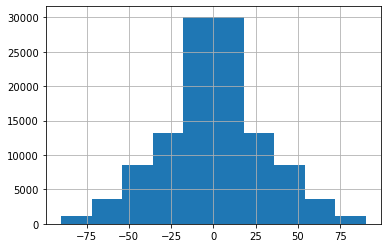

In [194]:
gdf[gdf['key'] == 0]['angle_deg'].hist()

In [198]:
len(gdf[gdf['obstructed'] == 1])/len(gdf)

0.043673448643886906

In [221]:
gdf['osmid'] = gdf.index

In [222]:
gdf.to_file("../test/obstructed.shp")

In [23]:
with open("../data/streetphotos/all_pts_2_low_gamma.pkl",'wb') as pklfile:
    pkl.dump(all_pts_2, pklfile)

In [22]:
with open("../data/streetphotos/all_pts_1_low_gamma.pkl",'wb') as pklfile:
    pkl.dump(all_pts_1, pklfile)

In [21]:
all_pts_1

,direction,obstructions,surface,point
0,left,4,0,"(-71.14017330550087, 42.34258870815954)"
1,right,3,1,"(-71.14261819272815, 42.36309112431179)"
2,right,2,2,"(-71.1659637694247, 42.349491502770285)"
3,right,2,0,"(-71.14030448636086, 42.36097811455067)"
4,right,6,0,"(-71.16516192431138, 42.351975036388254)"
5,left,2,0,"(-71.15341606674608, 42.346723711151974)"
6,left,4,0,"(-71.15930721062891, 42.346001577643875)"
7,left,3,0,"(-71.15668118810075, 42.34224332882101)"
8,left,3,0,"(-71.13761371362699, 42.34464637452116)"
9,right,2,0,"(-71.1435695565705, 42.34257125400752)"
